In [3]:
import pandas as pd

# === 1️⃣ File path ===
file_path = r"C:\Users\PC\Downloads\male_players.csv\male_players.csv"  # change if filename differs

# === 2️⃣ Define useful columns ===
useful_columns = [
    'player_id','short_name','long_name','age','dob',
    'height_cm','weight_kg','nationality_name','club_name','league_name',
    'value_eur','wage_eur','release_clause_eur',
    'overall','potential','international_reputation','weak_foot','skill_moves',
    'pace','shooting','passing','dribbling','defending','physic',
    'player_positions'
]

# === 3️⃣ Preload only column names ===
cols = pd.read_csv(file_path, nrows=0).columns.tolist()
usecols = [c for c in useful_columns if c in cols]

# === 4️⃣ Optimize dtypes for memory ===
dtype_map = {}
for c in ['age','overall','potential','international_reputation','weak_foot','skill_moves']:
    if c in usecols: dtype_map[c] = 'Int8'
for c in ['height_cm','weight_kg','pace','shooting','passing','dribbling','defending','physic',
          'value_eur','wage_eur','release_clause_eur']:
    if c in usecols: dtype_map[c] = 'float32'
for c in ['short_name','long_name','nationality_name','club_name','league_name','player_positions','dob','player_id']:
    if c in usecols and c not in dtype_map: dtype_map[c] = 'object'

# === 5️⃣ Process in chunks ===
chunksize = 200_000
filtered_chunks = []

for chunk in pd.read_csv(file_path, usecols=usecols, dtype=dtype_map, chunksize=chunksize, low_memory=True):
    # Drop rows missing target (value_eur)
    chunk = chunk.dropna(subset=['value_eur'])
    
    # Optional: keep only realistic ages (e.g., 15–45)
    if 'age' in chunk.columns:
        chunk = chunk[(chunk['age'] >= 15) & (chunk['age'] <= 45)]
    
    # Convert floats to smaller type
    for col in chunk.select_dtypes(include='float64').columns:
        chunk[col] = chunk[col].astype('float32')
    
    # Append cleaned chunk
    filtered_chunks.append(chunk)

# === 6️⃣ Combine all chunks into one DataFrame ===
df = pd.concat(filtered_chunks, ignore_index=True)

# === 7️⃣ Save smaller version for reuse ===
df.to_parquet("fifa23_clean.parquet", index=False)

# === 8️⃣ Confirm success ===
print("✅ Data successfully loaded and saved!")
print("Shape:", df.shape)
print("Memory usage (MB):", round(df.memory_usage(deep=True).sum() / 1024**2, 2))
df.head()


✅ Data successfully loaded and saved!
Shape: (9870595, 25)
Memory usage (MB): 5189.75


,player_id,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,...,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic
0,158023,L. Messi,Lionel Andrés Messi Cuccittini,RW,91,91,54000000.0,195000.0,35,1987-06-24,...,4,4,5,99900000.0,81.0,89.0,90.0,94.0,34.0,64.0
1,165153,K. Benzema,Karim Benzema,"CF, ST",91,91,64000000.0,450000.0,34,1987-12-19,...,4,4,4,131200000.0,80.0,88.0,83.0,87.0,39.0,78.0
2,188545,R. Lewandowski,Robert Lewandowski,ST,91,91,84000000.0,420000.0,33,1988-08-21,...,4,4,5,172200000.0,75.0,91.0,79.0,86.0,44.0,83.0
3,192985,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,107500000.0,350000.0,31,1991-06-28,...,5,4,4,198900000.0,74.0,88.0,93.0,87.0,63.0,77.0
4,231747,K. Mbappé,Kylian Mbappé Lottin,"ST, LW",91,95,190500000.0,230000.0,23,1998-12-20,...,4,5,4,366700000.0,97.0,89.0,80.0,92.0,36.0,76.0


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df = pd.read_parquet("fifa23_clean.parquet")

# Overview
print("Shape:", df.shape)
print("\nColumn Info:")
print(df.info())

# Summary stats
df.describe().T.head(15)


Shape: (9870595, 25)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9870595 entries, 0 to 9870594
Data columns (total 25 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   player_id                 object 
 1   short_name                object 
 2   long_name                 object 
 3   player_positions          object 
 4   overall                   Int8   
 5   potential                 Int8   
 6   value_eur                 float32
 7   wage_eur                  float32
 8   age                       Int8   
 9   dob                       object 
 10  height_cm                 float32
 11  weight_kg                 float32
 12  league_name               object 
 13  club_name                 object 
 14  nationality_name          object 
 15  weak_foot                 Int8   
 16  skill_moves               Int8   
 17  international_reputation  Int8   
 18  release_clause_eur        float32
 19  pace                      fl

,count,mean,std,min,25%,50%,75%,max
overall,9870595.0,65.793412,7.040664,35.0,61.0,66.0,70.0,94.0
potential,9870595.0,70.813668,6.2302,43.0,67.0,71.0,75.0,98.0
value_eur,9870595.0,2292391.5,5781966.5,1000.0,325000.0,725000.0,1800000.0,194000000.0
wage_eur,9870595.0,11032.298828,22084.273438,500.0,2000.0,4000.0,10000.0,575000.0
age,9870595.0,24.797428,4.67126,15.0,21.0,24.0,28.0,45.0
height_cm,9870595.0,181.237961,6.747039,149.0,176.0,181.0,186.0,210.0
weight_kg,9870595.0,75.241333,7.005772,48.0,70.0,75.0,80.0,110.0
weak_foot,9870595.0,2.941651,0.662382,1.0,3.0,3.0,3.0,5.0
skill_moves,9870595.0,2.331997,0.7539,1.0,2.0,2.0,3.0,5.0
international_reputation,9870595.0,1.109218,0.385996,1.0,1.0,1.0,1.0,5.0


release_clause_eur    3961272
physic                1103222
defending             1103222
shooting              1103222
pace                  1103222
passing               1103222
dribbling             1103222
league_name               423
club_name                 423
dtype: int64


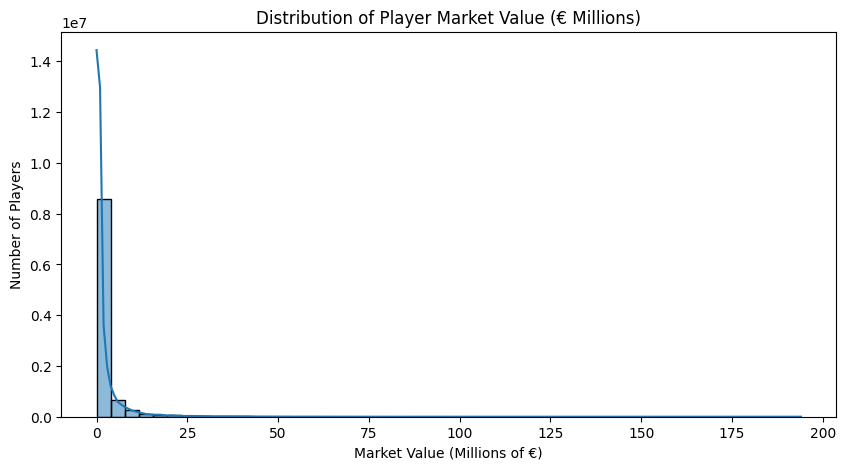

In [13]:
# Check missing values
missing = df.isnull().sum().sort_values(ascending=False)
print(missing[missing > 0])

# Quick distribution of player market values
plt.figure(figsize=(10,5))
sns.histplot(df['value_eur']/1e6, bins=50, kde=True)
plt.title('Distribution of Player Market Value (€ Millions)')
plt.xlabel('Market Value (Millions of €)')
plt.ylabel('Number of Players')
plt.show()


In [14]:
# Handle missing data

# 1️⃣ Fill numeric attributes (replace with median to avoid bias)
num_cols = ['physic', 'defending', 'shooting', 'pace', 'passing', 'dribbling']
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# 2️⃣ Drop 'release_clause_eur' — too many missing values (almost 4M)
df.drop(columns=['release_clause_eur'], inplace=True)

# 3️⃣ Fill categorical attributes (league_name, club_name)
df['league_name'].fillna('Unknown', inplace=True)
df['club_name'].fillna('Unknown', inplace=True)

# 4️⃣ Confirm missing data
print("✅ Remaining missing values:")
print(df.isna().sum().sort_values(ascending=False).head(10))


C:\Users\PC\AppData\Local\Temp\ipykernel_3088\2919202101.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_3088\2919202101.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

✅ Remaining missing values:
player_id           0
short_name          0
long_name           0
player_positions    0
overall             0
potential           0
value_eur           0
wage_eur            0
age                 0
dob                 0
dtype: int64


C:\Users\PC\AppData\Local\Temp\ipykernel_3088\3169335493.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\PC\AppData\Local\Temp\ipykernel_3088\3169335493.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


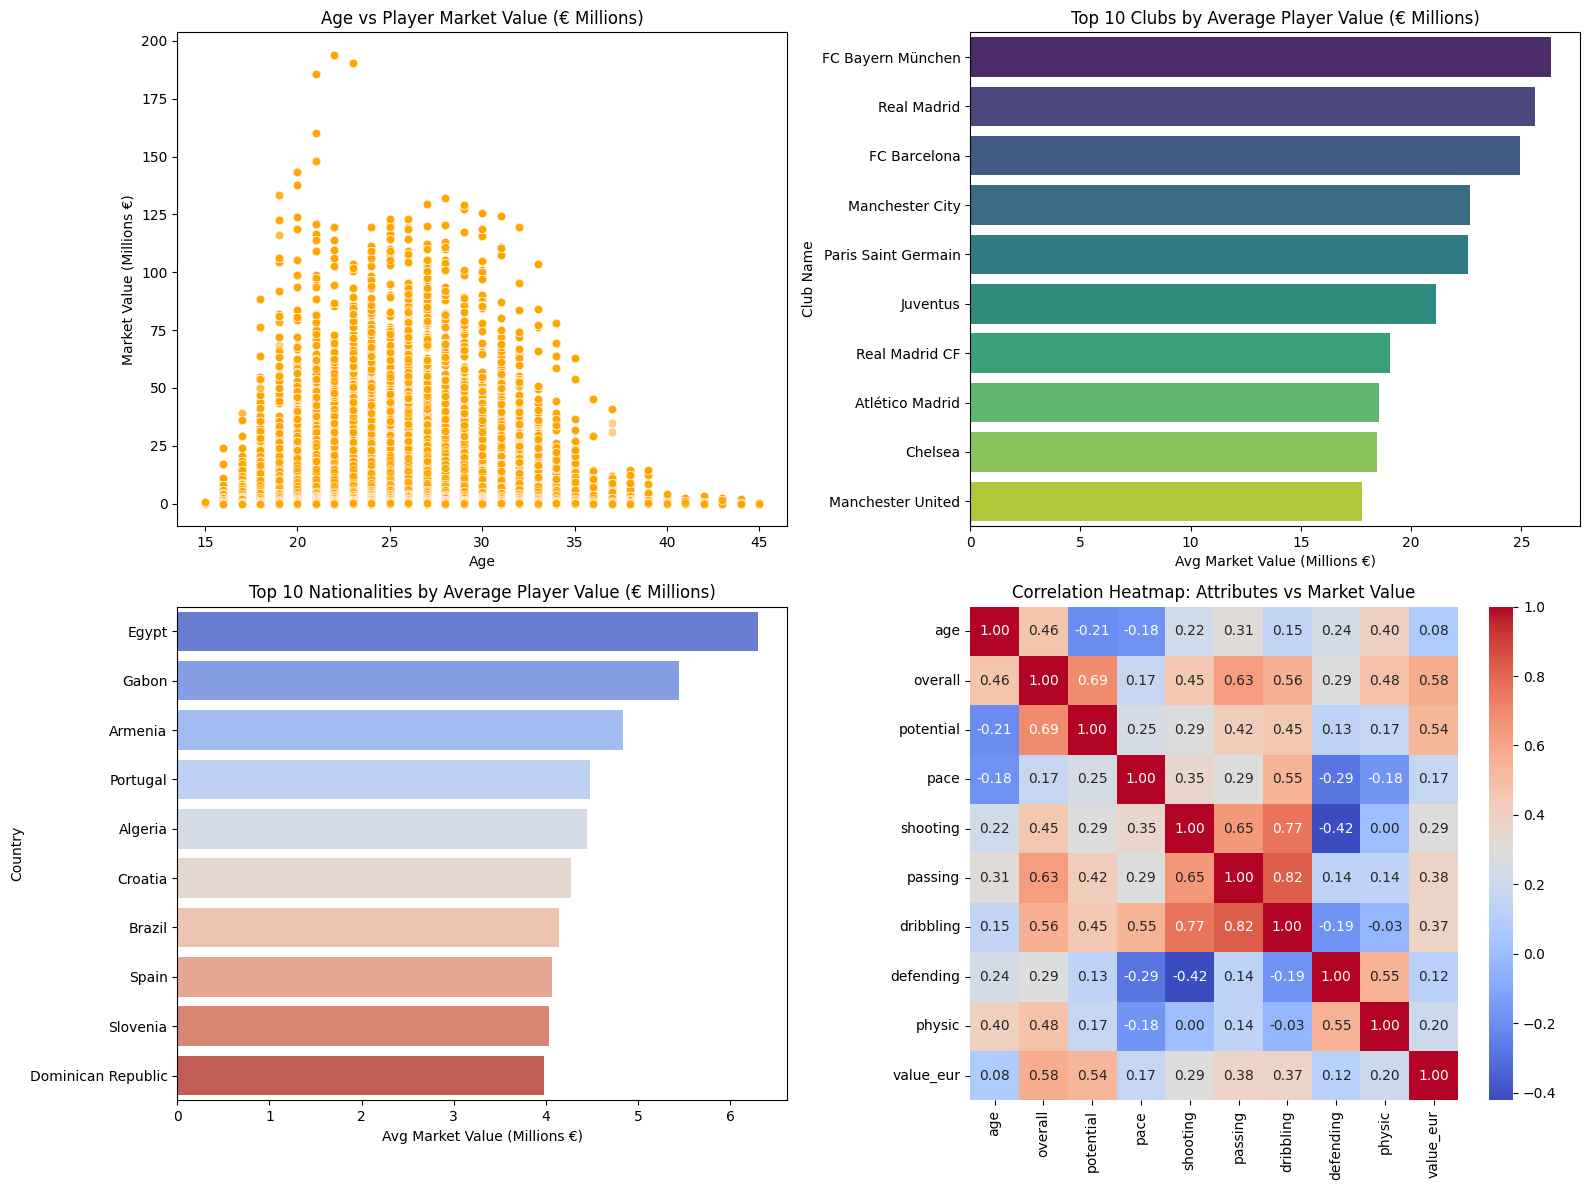

In [15]:
# Create figure grid (2 rows × 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# === 1️⃣ Age vs Market Value ===
sns.scatterplot(
    x='age', y=df['value_eur']/1e6, data=df,
    alpha=0.5, ax=axes[0], color='orange'
)
axes[0].set_title('Age vs Player Market Value (€ Millions)')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Market Value (Millions €)')

# === 2️⃣ Top 10 Clubs by Average Player Value ===
top_clubs = (
    df.groupby('club_name')['value_eur']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
sns.barplot(
    x=top_clubs.values/1e6, y=top_clubs.index,
    ax=axes[1], palette='viridis'
)
axes[1].set_title('Top 10 Clubs by Average Player Value (€ Millions)')
axes[1].set_xlabel('Avg Market Value (Millions €)')
axes[1].set_ylabel('Club Name')

# === 3️⃣ Top 10 Nationalities by Player Value ===
top_countries = (
    df.groupby('nationality_name')['value_eur']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
sns.barplot(
    x=top_countries.values/1e6, y=top_countries.index,
    ax=axes[2], palette='coolwarm'
)
axes[2].set_title('Top 10 Nationalities by Average Player Value (€ Millions)')
axes[2].set_xlabel('Avg Market Value (Millions €)')
axes[2].set_ylabel('Country')

# === 4️⃣ Correlation Heatmap ===
numeric_cols = [
    'age','overall','potential','pace','shooting',
    'passing','dribbling','defending','physic','value_eur'
]
corr = df[numeric_cols].corr()
sns.heatmap(
    corr, annot=True, cmap='coolwarm',
    fmt=".2f", ax=axes[3]
)
axes[3].set_title('Correlation Heatmap: Attributes vs Market Value')

# Adjust layout
plt.tight_layout()
plt.show()


C:\Users\PC\AppData\Local\Temp\ipykernel_3088\3035251484.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_3088\3035251484.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

✅ Encoding complete. Shape of X: (9870595, 23)
✅ Shape of y: (9870595,)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=400, subsample=1.0; total time=  12.9s
[CV] END colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=400, subsample=1.0; total time=   7.9s
[CV] END colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=400, subsample=1.0; total time=   8.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=600, subsample=0.8; total time=  14.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=600, subsample=0.8; total time=  16.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=600, subsample=0.8; total time=  

C:\Users\PC\AppData\Local\Temp\ipykernel_3088\3035251484.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(15), y=importances.head(15).index, palette='viridis')


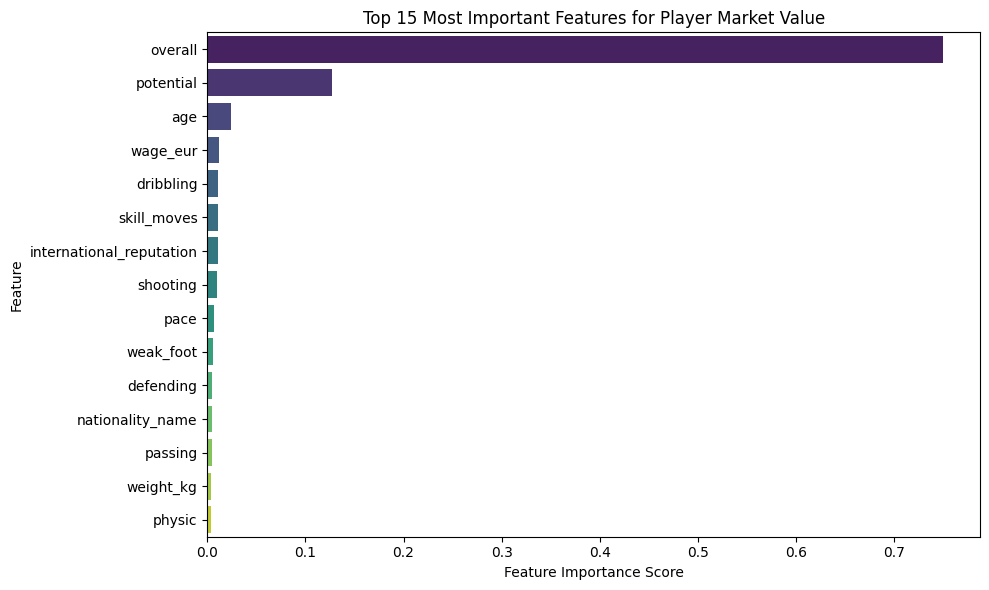

In [24]:
import numpy as np
# ==============================
# ⚽ FIFA 23 Player Value Prediction
# ==============================

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor


# ===============================
# 🧹 Data Cleaning
# ===============================
num_cols = df.select_dtypes(include=np.number).columns.tolist()

# Fill numeric missing with median
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Fill categorical missing
df['league_name'].fillna('Unknown', inplace=True)
df['club_name'].fillna('Unknown', inplace=True)
df['nationality_name'].fillna('Unknown', inplace=True)

# ===============================
# 🎯 Feature & Target
# ===============================
# keep original X for inspection, but create a numeric-only dataframe for modeling to save memory
X = df.drop(columns=['value_eur'])
y = df['value_eur']

# Reset index to align X and y perfectly
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Encode categorical features safely
from sklearn.preprocessing import LabelEncoder
le_dict = {}
cat_cols = ['club_name', 'league_name', 'nationality_name']

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le  # save encoder for future use (optional)

print("✅ Encoding complete. Shape of X:", X.shape)
print("✅ Shape of y:", y.shape)
# Drop text/string columns that are not needed by the model to reduce memory footprint
drop_cols = ['player_id', 'short_name', 'long_name', 'player_positions', 'dob']
X_model = X.drop(columns=drop_cols, errors='ignore')

# Keep only numeric dtypes (saves memory and prevents expensive object->numeric conversions)
X_model = X_model.select_dtypes(include=[np.number]).copy()

# Split dataset (we'll sample the training set for hyperparameter search to avoid MemoryError)
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.2, random_state=42
)

# ===============================
# ⚡ XGBoost Model + RandomizedSearchCV
# ===============================
# set estimator to use 1 job to avoid extra memory pressure during CV on very large datasets
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_jobs=1,
    random_state=42
)

param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 3, 5]
}

# Use a single job for RandomizedSearchCV (already avoids parallel CV memory spikes)
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1
)

# IMPORTANT: sample the training data for hyperparameter search to avoid MemoryError
# choose a sample size that fits in memory (adjust if you have more memory)
sample_size = min(200_000, X_train.shape[0])  # use up to 200k rows for tuning
X_train_sample = X_train.sample(n=sample_size, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

random_search.fit(X_train_sample, y_train_sample)

print("✅ Best Parameters:", random_search.best_params_)

# ===============================
# 🧠 Evaluate Model
# ===============================
best_model = random_search.best_estimator_

# evaluate on a sample of the test set if the full test set is very large
if X_test.shape[0] > 200_000:
    eval_size = 100_000
    X_test_eval = X_test.sample(n=eval_size, random_state=42)
    y_test_eval = y_test.loc[X_test_eval.index]
else:
    X_test_eval = X_test
    y_test_eval = y_test

y_pred = best_model.predict(X_test_eval)

rmse = np.sqrt(mean_squared_error(y_test_eval, y_pred))
r2 = r2_score(y_test_eval, y_pred)

print(f"🏁 RMSE: {rmse:,.2f}")
print(f"📈 R² Score: {r2:.4f}")

# ===============================
# 🌟 Feature Importance
# ===============================
# ensure index aligns with the features used for modeling
importances = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.head(15), y=importances.head(15).index, palette='viridis')
plt.title("Top 15 Most Important Features for Player Market Value")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [26]:
# ===============================
# 📊 Model Performance Analysis
# ===============================

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Player Market Value")
plt.grid(True)
plt.show()

# Residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals / 1e6, bins=50, kde=True, color='teal')
plt.title("Distribution of Prediction Errors (in Millions €)")
plt.xlabel("Error (Millions €)")
plt.show()

# Print performance summary
print("✅ Model Performance Summary")
print(f"RMSE: {rmse:,.2f} €")
print(f"R² Score: {r2:.4f}")

if r2 > 0.85:
    print("🔥 Excellent model fit! Ready for deployment.")
elif r2 > 0.7:
    print("✅ Good performance — can still be tuned further.")
else:
    print("⚠️ Might need more tuning or feature engineering.")


ValueError: array length 100000 does not match index length 1974119

<Figure size 800x600 with 0 Axes>

In [28]:
import joblib

# Save the trained model
joblib.dump(best_model, "player_value_model.pkl")

print("✅ Model saved successfully as 'player_value_model.pkl'")


✅ Model saved successfully as 'player_value_model.pkl'


In [29]:
# =======================================
# ⚽ AI Football Player Market Value Predictor
# =======================================
import streamlit as st
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBRegressor
import plotly.graph_objects as go

# ================================
# 🎯 Load Model & Data
# ================================
model = joblib.load("player_value_model.pkl")

# Optionally, load label encoders if you saved them
try:
    le_dict = joblib.load("label_encoders.pkl")
except:
    le_dict = None

# Some demo data for dropdowns
leagues = ['Premier League', 'La Liga', 'Serie A', 'Bundesliga', 'Ligue 1', 'Unknown']
clubs = ['Manchester City', 'Real Madrid', 'PSG', 'Barcelona', 'Liverpool', 'Unknown']
nations = ['England', 'Spain', 'France', 'Germany', 'Argentina', 'Brazil', 'Unknown']

# ================================
# 🖼️ Page Config
# ================================
st.set_page_config(
    page_title="Football Player Value Predictor",
    page_icon="⚽",
    layout="wide"
)

st.title("⚽ AI-Powered Football Player Value Predictor")
st.markdown("### Estimate player market value based on skills, stats, and attributes.")

st.info("Built using **XGBoost + Streamlit** — trained on FIFA 23 dataset. 🔥")

# ================================
# 📊 Input Section
# ================================
col1, col2, col3 = st.columns(3)

with col1:
    age = st.slider("Age", 16, 45, 25)
    height_cm = st.slider("Height (cm)", 150, 210, 180)
    weight_kg = st.slider("Weight (kg)", 50, 120, 75)
    wage_eur = st.number_input("Weekly Wage (€)", 1000, 1000000, 50000, step=1000)

with col2:
    overall = st.slider("Overall Rating", 40, 99, 80)
    potential = st.slider("Potential", 40, 99, 85)
    international_reputation = st.slider("International Reputation (1–5)", 1, 5, 3)
    weak_foot = st.slider("Weak Foot (1–5)", 1, 5, 3)

with col3:
    pace = st.slider("Pace", 0, 99, 75)
    shooting = st.slider("Shooting", 0, 99, 70)
    passing = st.slider("Passing", 0, 99, 72)
    dribbling = st.slider("Dribbling", 0, 99, 74)
    defending = st.slider("Defending", 0, 99, 60)
    physic = st.slider("Physical", 0, 99, 68)

st.markdown("---")

col4, col5, col6 = st.columns(3)

with col4:
    league_name = st.selectbox("League", leagues)

with col5:
    club_name = st.selectbox("Club", clubs)

with col6:
    nationality_name = st.selectbox("Nationality", nations)

# ================================
# 🧮 Data Preparation
# ================================
input_data = pd.DataFrame({
    'age': [age],
    'height_cm': [height_cm],
    'weight_kg': [weight_kg],
    'overall': [overall],
    'potential': [potential],
    'wage_eur': [wage_eur],
    'international_reputation': [international_reputation],
    'weak_foot': [weak_foot],
    'pace': [pace],
    'shooting': [shooting],
    'passing': [passing],
    'dribbling': [dribbling],
    'defending': [defending],
    'physic': [physic],
    'club_name': [club_name],
    'league_name': [league_name],
    'nationality_name': [nationality_name]
})

# Encode categorical columns if encoder exists
if le_dict:
    for col in ['club_name', 'league_name', 'nationality_name']:
        if col in input_data.columns:
            input_data[col] = le_dict[col].transform(
                input_data[col].astype(str)
                .where(input_data[col].isin(le_dict[col].classes_), 'Unknown')
            )

# ================================
# 🧠 Predict Player Value
# ================================
if st.button("💰 Predict Player Market Value"):
    prediction = model.predict(input_data)[0]
    st.success(f"🏆 Estimated Market Value: **€{prediction:,.0f}**")
    st.balloons()

    # ================================
    # ⚔️ Radar Chart Comparison
    # ================================
    stars = {
        "K. Mbappé": [97, 92, 85, 90, 38, 77],
        "E. Haaland": [91, 94, 65, 80, 45, 88],
        "L. Messi": [85, 89, 91, 94, 35, 64],
    }

    player_stats = [pace, shooting, passing, dribbling, defending, physic]

    fig = go.Figure()

    categories = ['Pace', 'Shooting', 'Passing', 'Dribbling', 'Defending', 'Physical']

    # Player stats
    fig.add_trace(go.Scatterpolar(
        r=player_stats,
        theta=categories,
        fill='toself',
        name="Your Player",
        line_color='green'
    ))

    # Compare with 3 top stars
    for name, stats in stars.items():
        fig.add_trace(go.Scatterpolar(
            r=stats,
            theta=categories,
            fill='toself',
            name=name
        ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(visible=True, range=[0, 100])
        ),
        showlegend=True,
        title="⚔️ Player Profile Comparison with World-Class Players"
    )

    st.plotly_chart(fig, use_container_width=True)

# ================================
# 🏁 Footer
# ================================
st.markdown("---")
st.caption("Built with ❤️ using Streamlit and XGBoost | © 2025 Football AI Lab")


2025-10-24 07:45:16.263 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-24 07:45:16.266 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-24 07:45:16.581 
  command:

    streamlit run C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-10-24 07:45:16.584 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-24 07:45:16.585 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-24 07:45:16.586 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-24 07:45:16.587 Thread 'MainThread': missing ScriptRunContext! This warning can be i

DeltaGenerator()